In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import xgboost as xgb
print("xgb.__version__:", xgb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

xgb.__version__: 2.1.1


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [3]:
# input parameters
fs_type = 'fsv24'
train_type = "small"

In [4]:
# Parameters
fs_type = "int96"


In [5]:
# Load the feature selection results
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 150
Categorical features: 7
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0
number of constant cols:  0


Numerical Columns: 222
Categorical Columns: 7


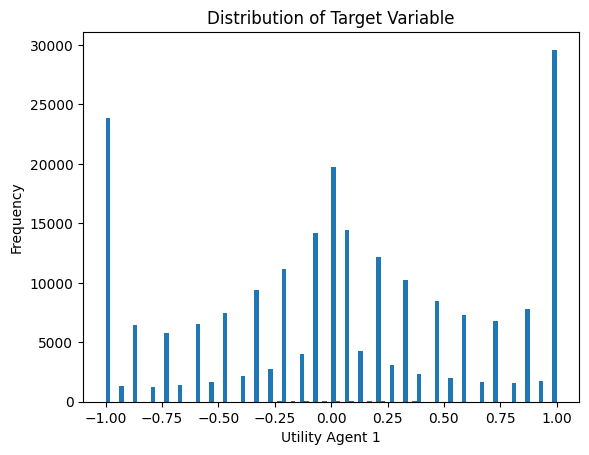

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model


In [9]:
if train_type == "small":
    LEARNING_RATE = 0.03
    NUM_BOOST_ROUND = 2500
elif train_type == "medium":
    LEARNING_RATE = 0.01
    NUM_BOOST_ROUND = 5000
elif train_type == "large":
    LEARNING_RATE = 0.005
    NUM_BOOST_ROUND = 10_000
elif train_type == "xlarge":
    LEARNING_RATE = 0.001
    NUM_BOOST_ROUND = 20_000


print(LEARNING_RATE, NUM_BOOST_ROUND)

0.03 2500


In [10]:
def train_models(
        df_train,
        target,
        numerical_cols,
        categorical_cols,
        split_list=None
    ):
    # Define the parameters
    params = {
        'objective': "reg:squarederror",
        'eval_metric': 'rmse',
        'max_depth': 8,
        'max_bin': 128,
        'learning_rate': LEARNING_RATE,
        'alpha': 0.1,
        'colsample_bytree': 0.5,
        'subsample': 0.8,
        'min_child_weight': 10,
        'seed': 2112,
        'verbosity': 0,
    }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]

        feature_types = [
            "c" if col in categorical_cols else "q" 
            for col in numerical_cols + categorical_cols
        ]
        
        # Convert to DMatrix format
        train_data = xgb.DMatrix(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            feature_types=feature_types,
            enable_categorical=True,
            feature_names=numerical_cols + categorical_cols
        )
        val_data = xgb.DMatrix(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            feature_types=feature_types,
            enable_categorical=True,
            feature_names=numerical_cols + categorical_cols
        )

        # Train the model
        model = xgb.train(
            params,
            train_data,
            num_boost_round=NUM_BOOST_ROUND,
            evals=[(val_data, 'val')],
            verbose_eval=100,
        )
        
        # Get feature importance
        importance_dict = model.get_score(importance_type='gain')
        feat_importance = pd.DataFrame(
            {'feature': list(importance_dict.keys()),
             f'importance_f{fold}': list(importance_dict.values())}
        )
        feat_importance_dfs.append(feat_importance)
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(val_data)

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold

        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores, importance_df

In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv1.parquet', index=False)

Fold 1


[0]	val-rmse:0.55446


[100]	val-rmse:0.46809


[200]	val-rmse:0.44906


[300]	val-rmse:0.43980


[400]	val-rmse:0.43464


[500]	val-rmse:0.43186


[600]	val-rmse:0.43011


[700]	val-rmse:0.42886


[800]	val-rmse:0.42826


[900]	val-rmse:0.42775


[1000]	val-rmse:0.42744


[1100]	val-rmse:0.42708


[1200]	val-rmse:0.42679


[1300]	val-rmse:0.42648


[1400]	val-rmse:0.42641


[1500]	val-rmse:0.42632


[1600]	val-rmse:0.42631


[1700]	val-rmse:0.42627


[1800]	val-rmse:0.42632


[1900]	val-rmse:0.42615


[2000]	val-rmse:0.42622


[2100]	val-rmse:0.42625


[2200]	val-rmse:0.42619


[2300]	val-rmse:0.42633


[2400]	val-rmse:0.42638


[2499]	val-rmse:0.42647


Fold 1 - RMSE: 0.42612217203680397
Fold 2


[0]	val-rmse:0.58929


[100]	val-rmse:0.48203


[200]	val-rmse:0.46556


[300]	val-rmse:0.45852


[400]	val-rmse:0.45431


[500]	val-rmse:0.45193


[600]	val-rmse:0.45043


[700]	val-rmse:0.44952


[800]	val-rmse:0.44898


[900]	val-rmse:0.44851


[1000]	val-rmse:0.44834


[1100]	val-rmse:0.44797


[1200]	val-rmse:0.44781


[1300]	val-rmse:0.44763


[1400]	val-rmse:0.44727


[1500]	val-rmse:0.44722


[1600]	val-rmse:0.44713


[1700]	val-rmse:0.44681


[1800]	val-rmse:0.44671


[1900]	val-rmse:0.44662


[2000]	val-rmse:0.44670


[2100]	val-rmse:0.44656


[2200]	val-rmse:0.44648


[2300]	val-rmse:0.44640


[2400]	val-rmse:0.44632


[2499]	val-rmse:0.44635


Fold 2 - RMSE: 0.44603379533187804
Fold 3


[0]	val-rmse:0.60772


[100]	val-rmse:0.48009


[200]	val-rmse:0.45998


[300]	val-rmse:0.45190


[400]	val-rmse:0.44812


[500]	val-rmse:0.44574


[600]	val-rmse:0.44431


[700]	val-rmse:0.44345


[800]	val-rmse:0.44278


[900]	val-rmse:0.44238


[1000]	val-rmse:0.44198


[1100]	val-rmse:0.44168


[1200]	val-rmse:0.44147


[1300]	val-rmse:0.44105


[1400]	val-rmse:0.44084


[1500]	val-rmse:0.44062


[1600]	val-rmse:0.44063


[1700]	val-rmse:0.44050


[1800]	val-rmse:0.44048


[1900]	val-rmse:0.44052


[2000]	val-rmse:0.44042


[2100]	val-rmse:0.44035


[2200]	val-rmse:0.44027


[2300]	val-rmse:0.44036


[2400]	val-rmse:0.44042


[2499]	val-rmse:0.44045


Fold 3 - RMSE: 0.43995643496667736
Fold 4


[0]	val-rmse:0.59715


[100]	val-rmse:0.48082


[200]	val-rmse:0.46209


[300]	val-rmse:0.45310


[400]	val-rmse:0.44799


[500]	val-rmse:0.44516


[600]	val-rmse:0.44344


[700]	val-rmse:0.44218


[800]	val-rmse:0.44132


[900]	val-rmse:0.44064


[1000]	val-rmse:0.44023


[1100]	val-rmse:0.43986


[1200]	val-rmse:0.43964


[1300]	val-rmse:0.43957


[1400]	val-rmse:0.43934


[1500]	val-rmse:0.43908


[1600]	val-rmse:0.43871


[1700]	val-rmse:0.43851


[1800]	val-rmse:0.43846


[1900]	val-rmse:0.43844


[2000]	val-rmse:0.43835


[2100]	val-rmse:0.43835


[2200]	val-rmse:0.43832


[2300]	val-rmse:0.43822


[2400]	val-rmse:0.43816


[2499]	val-rmse:0.43820


Fold 4 - RMSE: 0.437773187482573
Fold 5


[0]	val-rmse:0.54853


[100]	val-rmse:0.45712


[200]	val-rmse:0.43517


[300]	val-rmse:0.42377


[400]	val-rmse:0.41744


[500]	val-rmse:0.41419


[600]	val-rmse:0.41237


[700]	val-rmse:0.41111


[800]	val-rmse:0.41002


[900]	val-rmse:0.40935


[1000]	val-rmse:0.40873


[1100]	val-rmse:0.40824


[1200]	val-rmse:0.40778


[1300]	val-rmse:0.40759


[1400]	val-rmse:0.40736


[1500]	val-rmse:0.40726


[1600]	val-rmse:0.40697


[1700]	val-rmse:0.40689


[1800]	val-rmse:0.40677


[1900]	val-rmse:0.40675


[2000]	val-rmse:0.40679


[2100]	val-rmse:0.40679


[2200]	val-rmse:0.40690


[2300]	val-rmse:0.40683


[2400]	val-rmse:0.40698


[2499]	val-rmse:0.40710


Fold 5 - RMSE: 0.40679792971920176
List of oof scores: [0.42612217203680397, 0.44603379533187804, 0.43995643496667736, 0.437773187482573, 0.40679792971920176]
Average oof score: 0.43133670390742684


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv2.parquet', index=False)

Fold 1


[0]	val-rmse:0.53594


[100]	val-rmse:0.45058


[200]	val-rmse:0.43282


[300]	val-rmse:0.42443


[400]	val-rmse:0.41993


[500]	val-rmse:0.41710


[600]	val-rmse:0.41531


[700]	val-rmse:0.41402


[800]	val-rmse:0.41301


[900]	val-rmse:0.41245


[1000]	val-rmse:0.41179


[1100]	val-rmse:0.41123


[1200]	val-rmse:0.41091


[1300]	val-rmse:0.41073


[1400]	val-rmse:0.41049


[1500]	val-rmse:0.41040


[1600]	val-rmse:0.41008


[1700]	val-rmse:0.41004


[1800]	val-rmse:0.40999


[1900]	val-rmse:0.40982


[2000]	val-rmse:0.40971


[2100]	val-rmse:0.40978


[2200]	val-rmse:0.40974


[2300]	val-rmse:0.40965


[2400]	val-rmse:0.40973


[2499]	val-rmse:0.40980


Fold 1 - RMSE: 0.40954420064567343
Fold 2


[0]	val-rmse:0.54691


[100]	val-rmse:0.43596


[200]	val-rmse:0.41920


[300]	val-rmse:0.41279


[400]	val-rmse:0.40931


[500]	val-rmse:0.40755


[600]	val-rmse:0.40680


[700]	val-rmse:0.40586


[800]	val-rmse:0.40542


[900]	val-rmse:0.40503


[1000]	val-rmse:0.40491


[1100]	val-rmse:0.40460


[1200]	val-rmse:0.40452


[1300]	val-rmse:0.40459


[1400]	val-rmse:0.40457


[1500]	val-rmse:0.40459


[1600]	val-rmse:0.40456


[1700]	val-rmse:0.40468


[1800]	val-rmse:0.40464


[1900]	val-rmse:0.40471


[2000]	val-rmse:0.40474


[2100]	val-rmse:0.40486


[2200]	val-rmse:0.40488


[2300]	val-rmse:0.40503


[2400]	val-rmse:0.40524


[2499]	val-rmse:0.40535


Fold 2 - RMSE: 0.40495612652544966
Fold 3


[0]	val-rmse:0.61465


[100]	val-rmse:0.49030


[200]	val-rmse:0.46728


[300]	val-rmse:0.45600


[400]	val-rmse:0.45002


[500]	val-rmse:0.44625


[600]	val-rmse:0.44416


[700]	val-rmse:0.44273


[800]	val-rmse:0.44152


[900]	val-rmse:0.44047


[1000]	val-rmse:0.43975


[1100]	val-rmse:0.43927


[1200]	val-rmse:0.43888


[1300]	val-rmse:0.43841


[1400]	val-rmse:0.43813


[1500]	val-rmse:0.43784


[1600]	val-rmse:0.43768


[1700]	val-rmse:0.43742


[1800]	val-rmse:0.43729


[1900]	val-rmse:0.43704


[2000]	val-rmse:0.43698


[2100]	val-rmse:0.43698


[2200]	val-rmse:0.43696


[2300]	val-rmse:0.43698


[2400]	val-rmse:0.43691


[2499]	val-rmse:0.43682


Fold 3 - RMSE: 0.4364189135746192
Fold 4


[0]	val-rmse:0.60642


[100]	val-rmse:0.49188


[200]	val-rmse:0.47045


[300]	val-rmse:0.46060


[400]	val-rmse:0.45544


[500]	val-rmse:0.45320


[600]	val-rmse:0.45157


[700]	val-rmse:0.45058


[800]	val-rmse:0.44956


[900]	val-rmse:0.44894


[1000]	val-rmse:0.44852


[1100]	val-rmse:0.44811


[1200]	val-rmse:0.44764


[1300]	val-rmse:0.44739


[1400]	val-rmse:0.44718


[1500]	val-rmse:0.44712


[1600]	val-rmse:0.44695


[1700]	val-rmse:0.44687


[1800]	val-rmse:0.44687


[1900]	val-rmse:0.44668


[2000]	val-rmse:0.44659


[2100]	val-rmse:0.44654


[2200]	val-rmse:0.44651


[2300]	val-rmse:0.44642


[2400]	val-rmse:0.44646


[2499]	val-rmse:0.44652


Fold 4 - RMSE: 0.44618832360409966
Fold 5


[0]	val-rmse:0.59137


[100]	val-rmse:0.48668


[200]	val-rmse:0.46451


[300]	val-rmse:0.45346


[400]	val-rmse:0.44782


[500]	val-rmse:0.44444


[600]	val-rmse:0.44252


[700]	val-rmse:0.44094


[800]	val-rmse:0.44004


[900]	val-rmse:0.43944


[1000]	val-rmse:0.43912


[1100]	val-rmse:0.43879


[1200]	val-rmse:0.43847


[1300]	val-rmse:0.43821


[1400]	val-rmse:0.43815


[1500]	val-rmse:0.43791


[1600]	val-rmse:0.43773


[1700]	val-rmse:0.43759


[1800]	val-rmse:0.43757


[1900]	val-rmse:0.43752


[2000]	val-rmse:0.43757


[2100]	val-rmse:0.43761


[2200]	val-rmse:0.43757


[2300]	val-rmse:0.43757


[2400]	val-rmse:0.43759


[2499]	val-rmse:0.43758


Fold 5 - RMSE: 0.4370550882636169
List of oof scores: [0.40954420064567343, 0.40495612652544966, 0.4364189135746192, 0.44618832360409966, 0.4370550882636169]
Average oof score: 0.42683253052269177


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv3.parquet', index=False)

Fold 1


[0]	val-rmse:0.57577


[100]	val-rmse:0.48004


[200]	val-rmse:0.46027


[300]	val-rmse:0.45147


[400]	val-rmse:0.44717


[500]	val-rmse:0.44456


[600]	val-rmse:0.44284


[700]	val-rmse:0.44196


[800]	val-rmse:0.44123


[900]	val-rmse:0.44090


[1000]	val-rmse:0.44051


[1100]	val-rmse:0.44037


[1200]	val-rmse:0.43998


[1300]	val-rmse:0.43970


[1400]	val-rmse:0.43958


[1500]	val-rmse:0.43954


[1600]	val-rmse:0.43954


[1700]	val-rmse:0.43945


[1800]	val-rmse:0.43939


[1900]	val-rmse:0.43931


[2000]	val-rmse:0.43935


[2100]	val-rmse:0.43935


[2200]	val-rmse:0.43931


[2300]	val-rmse:0.43927


[2400]	val-rmse:0.43935


[2499]	val-rmse:0.43941


Fold 1 - RMSE: 0.4390354382095266
Fold 2


[0]	val-rmse:0.57454


[100]	val-rmse:0.46658


[200]	val-rmse:0.44189


[300]	val-rmse:0.43044


[400]	val-rmse:0.42477


[500]	val-rmse:0.42119


[600]	val-rmse:0.41924


[700]	val-rmse:0.41767


[800]	val-rmse:0.41647


[900]	val-rmse:0.41570


[1000]	val-rmse:0.41525


[1100]	val-rmse:0.41497


[1200]	val-rmse:0.41460


[1300]	val-rmse:0.41426


[1400]	val-rmse:0.41410


[1500]	val-rmse:0.41374


[1600]	val-rmse:0.41356


[1700]	val-rmse:0.41337


[1800]	val-rmse:0.41333


[1900]	val-rmse:0.41323


[2000]	val-rmse:0.41315


[2100]	val-rmse:0.41316


[2200]	val-rmse:0.41311


[2300]	val-rmse:0.41317


[2400]	val-rmse:0.41318


[2499]	val-rmse:0.41320


Fold 2 - RMSE: 0.4129496491449189
Fold 3


[0]	val-rmse:0.57840


[100]	val-rmse:0.47595


[200]	val-rmse:0.45541


[300]	val-rmse:0.44746


[400]	val-rmse:0.44315


[500]	val-rmse:0.44068


[600]	val-rmse:0.43931


[700]	val-rmse:0.43796


[800]	val-rmse:0.43699


[900]	val-rmse:0.43655


[1000]	val-rmse:0.43619


[1100]	val-rmse:0.43585


[1200]	val-rmse:0.43546


[1300]	val-rmse:0.43518


[1400]	val-rmse:0.43499


[1500]	val-rmse:0.43493


[1600]	val-rmse:0.43474


[1700]	val-rmse:0.43466


[1800]	val-rmse:0.43459


[1900]	val-rmse:0.43444


[2000]	val-rmse:0.43447


[2100]	val-rmse:0.43443


[2200]	val-rmse:0.43443


[2300]	val-rmse:0.43440


[2400]	val-rmse:0.43450


[2499]	val-rmse:0.43455


Fold 3 - RMSE: 0.43426585405128504
Fold 4


[0]	val-rmse:0.57620


[100]	val-rmse:0.46351


[200]	val-rmse:0.44304


[300]	val-rmse:0.43393


[400]	val-rmse:0.42880


[500]	val-rmse:0.42577


[600]	val-rmse:0.42425


[700]	val-rmse:0.42333


[800]	val-rmse:0.42251


[900]	val-rmse:0.42178


[1000]	val-rmse:0.42138


[1100]	val-rmse:0.42095


[1200]	val-rmse:0.42071


[1300]	val-rmse:0.42048


[1400]	val-rmse:0.42014


[1500]	val-rmse:0.41997


[1600]	val-rmse:0.41972


[1700]	val-rmse:0.41976


[1800]	val-rmse:0.41971


[1900]	val-rmse:0.41960


[2000]	val-rmse:0.41954


[2100]	val-rmse:0.41945


[2200]	val-rmse:0.41948


[2300]	val-rmse:0.41950


[2400]	val-rmse:0.41966


[2499]	val-rmse:0.41961


Fold 4 - RMSE: 0.41929779237816617
Fold 5


[0]	val-rmse:0.58636


[100]	val-rmse:0.47898


[200]	val-rmse:0.45773


[300]	val-rmse:0.44666


[400]	val-rmse:0.44062


[500]	val-rmse:0.43704


[600]	val-rmse:0.43490


[700]	val-rmse:0.43319


[800]	val-rmse:0.43231


[900]	val-rmse:0.43143


[1000]	val-rmse:0.43096


[1100]	val-rmse:0.43037


[1200]	val-rmse:0.43004


[1300]	val-rmse:0.42988


[1400]	val-rmse:0.42973


[1500]	val-rmse:0.42949


[1600]	val-rmse:0.42933


[1700]	val-rmse:0.42924


[1800]	val-rmse:0.42900


[1900]	val-rmse:0.42900


[2000]	val-rmse:0.42890


[2100]	val-rmse:0.42890


[2200]	val-rmse:0.42883


[2300]	val-rmse:0.42887


[2400]	val-rmse:0.42891


[2499]	val-rmse:0.42897


Fold 5 - RMSE: 0.428585492861979
List of oof scores: [0.4390354382095266, 0.4129496491449189, 0.43426585405128504, 0.41929779237816617, 0.428585492861979]
Average oof score: 0.42682684532917514


In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")

CV1 OOF Scores:
Score: 0.4261
Score: 0.4460
Score: 0.4400
Score: 0.4378
Score: 0.4068
Average CV1 Score: 0.4313

CV2 OOF Scores:
Score: 0.4095
Score: 0.4050
Score: 0.4364
Score: 0.4462
Score: 0.4371
Average CV2 Score: 0.4268

CV3 OOF Scores:
Score: 0.4390
Score: 0.4129
Score: 0.4343
Score: 0.4193
Score: 0.4286
Average CV3 Score: 0.4268


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

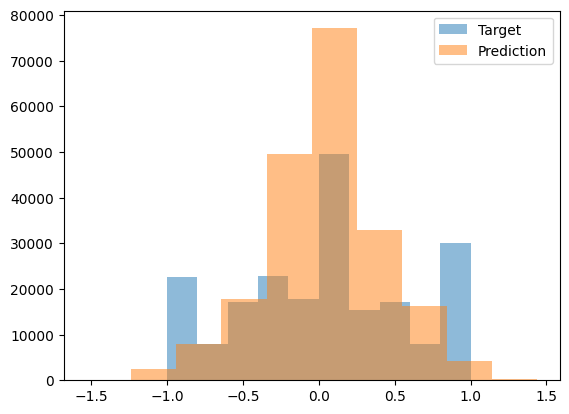

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Create feature types list for XGBoost
    feature_types = [
        "c" if col in categorical_cols else "q" 
        for col in numerical_cols + categorical_cols
    ]

    # Create XGBoost DMatrix for test data
    test_dmatrix = xgb.DMatrix(
        data=test_processed[numerical_cols + categorical_cols],
        feature_types=feature_types,
        enable_categorical=True
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_dmatrix)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [20]:
# Save all artifacts needed for prediction
xgboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'encoder': encoder,
    'scaler': scaler
}

with open(f'./xgboost_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(xgboost_predict, f)

***